In [1]:
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dropout
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
import re
from transformers import BertTokenizer, BertForSequenceClassification



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


predspracovanie

In [7]:
# Načítanie stop-slov pre anglický jazyk
stopwords = nltk.corpus.stopwords.words("english")
# Rozšírenie stop-slov o termíny charakteristické pre Twitter
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
# Inicializácia stemmera
stemmer = PorterStemmer()

def preprocess(tweet):
     # Odstránenie nadbytočných medzier na začiatku spracovania
    tweet_space = tweet.str.replace(r'\s+', ' ', regex=True)

    # Odstránenie používateľských spomenutí (učtov)
    tweet_name = tweet_space.str.replace(r'@[\w\-]+', '', regex=True)

    # Odstránenie odkazov
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*,]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '', regex=True)

    # Odstránenie interpunkcie a čísel
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ", regex=True)

    # Opätovné odstránenie nadbytočných medzier po odstránení interpunkcie a čísel
    newtweet = punc_remove.str.replace(r'\s+', ' ', regex=True)

    # Konverzia na malé písmená
    tweet_lower = newtweet.str.lower()

    # Tokenizácia
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

    # Odstránenie stop-slov a stemming
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x if i not in stopwords])

    # Spojenie tokenov do reťazca
    tokenized_tweet = tokenized_tweet.apply(lambda x: ' '.join(x))

    return tokenized_tweet


In [3]:
daмid = pd.read_csv('/content/drive/MyDrive/Data/labeled_data.csv')
dawid = dawid.drop(dawid.columns[0], axis=1)

dawid.loc[dawid['class'] == 0, 'class'] = 1
dawid.loc[dawid['class'] == 2, 'class'] = 0

dawid = dawid.drop(columns=['count','hate_speech','offensive_language','neither'])
dawid.to_csv('/content/drive/MyDrive/Data/all_data.csv', index=False)

    class                                              tweet
0       0  !!! RT @mayasolovely: As a woman you shouldn't...
1       1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2       1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3       1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4       1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
..    ...                                                ...
95      1  "@CauseWereGuys: Going back to school sucks mo...
96      1  "@CauseWereGuys: On my way to fuck yo bitch ht...
97      1  "@CeleyNichole: @white_thunduh how come you ne...
98      1  "@ChadMFVerbeck: If Richnow doesn't show up wi...
99      1  "@ChandlerParsons: How bout them Cowboys!!!!" ...

[100 rows x 2 columns]


In [3]:
dawid = pd.read_csv('all_data.csv')

# Pridanie nového stĺpca 'dĺžka textu', ktorý obsahuje dĺžku každého tweetu
dawid['dĺžka textu'] = dawid['tweet'].apply(len)

# Vypočítanie priemernej dĺžky tweetu
average_length = dawid['dĺžka textu'].mean()

# Vytlačenie priemernej dĺžky tweetu
print("priemerna dĺžka:", average_length)


priemerna dĺžka: 85.43606504458701


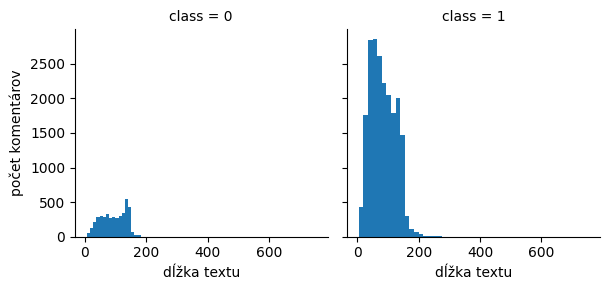

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt

# Vytvorenie FacetGrid
graph = sns.FacetGrid(data=dawid, col='class')

# Mapovanie histogramu
graph.map(plt.hist, 'dĺžka textu', bins=50)

# Nastavenie popisu osi y pre každý graf v mriežke
graph.set_ylabels('počet komentárov')

# Zobrazenie grafu
plt.show()


In [5]:
# Vypočítanie priemernej dĺžky textu pre toxické komentáre
avg_toxic_length = dawid[dawid['class'] == 1]['dĺžka textu'].mean()

# Vypočítanie priemernej dĺžky textu pre netoxické komentáre
avg_non_toxic_length = dawid[dawid['class'] == 0]['dĺžka textu'].mean()

# Porovnanie priemernej dĺžky textu pre toxické a netoxické komentáre
if avg_toxic_length > avg_non_toxic_length:
    print("Priemerná dĺžka toxických komentárov je väčšia ako priemerná dĺžka netoxických komentárov.")
elif avg_toxic_length < avg_non_toxic_length:
    print("Priemerná dĺžka toxických komentárov je menšia ako priemerná dĺžka netoxických komentárov.")
elif avg_toxic_length == avg_non_toxic_length:
  print("Priemerná dĺžka toxických komentárov sa rovná priemernej dĺžke netoxických komentárov.")
else:
    print("ERROR")


Priemerná dĺžka toxických komentárov je menšia ako priemerná dĺžka netoxických komentárov.


In [8]:
texts = dawid['tweet']
labels = dawid['class']

processed_tweets = preprocess(texts)
dawid['processed_tweets'] = processed_tweets
print(dawid[["tweet","processed_tweets"]].head(10))


                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
6  !!!!!!"@__BrighterDays: I can not just sit up ...   
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
8  " &amp; you might not get ya bitch back &amp; ...   
9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                    processed_tweets  
0  woman complain clean hous amp man alway take t...  
1  boy dat cold tyga dwn bad cuffin dat hoe st place  
2         dawg ever fuck bitch start cri confus shit  
3                                   look like tranni  
4     shit hear might true might faker bitch told ya  
5      shit blow claim faith somebodi still fuck hoe 

In [9]:
from collections import Counter

# Získanie zoznamu všetkých slov z upravených tweetov
all_words_list = [word for text in dawid['processed_tweets'] for word in text.split()]

# Spočítanie počtu výskytov každého slova
word_counts = Counter(all_words_list)

# Získanie top 10 najčastejšie sa vyskytujúcich slov
top_10_words = word_counts.most_common(10)

for word, count in top_10_words:
    print(word, "-", count)


bitch - 11480
hoe - 4352
like - 2873
fuck - 2269
pussi - 2267
nigga - 2019
get - 1785
ass - 1599
shit - 1312
u - 1307


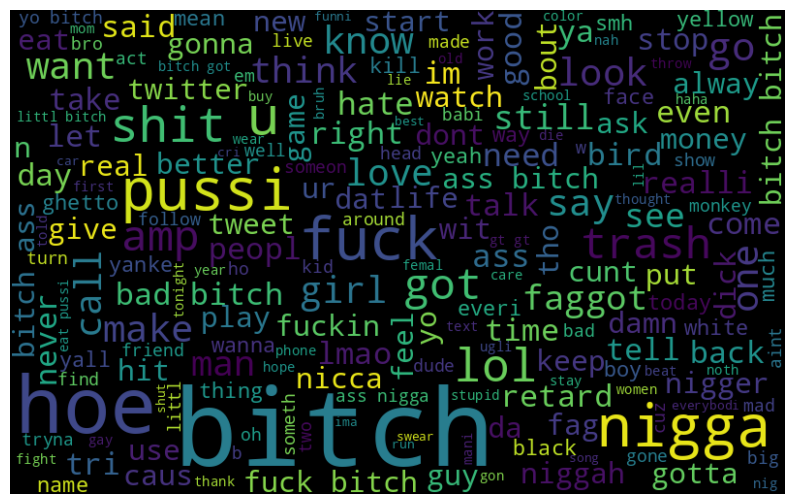

In [10]:
from wordcloud import WordCloud

# Získanie všetkých slov z upravených tweetov a spojenie do jedného reťazca
all_words = ' '.join([text for text in dawid['processed_tweets']])

# Vytvorenie wordcloudu
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# Vytvorenie obrázka wordcloudu
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')  # Vypnutie osí
plt.show()  # Zobrazenie wordcloudu


Toxic Tweets Dataset

In [13]:
toxic = pd.read_csv('data2.csv')
toxic = toxic.drop('Unnamed: 0', axis=1)
toxic['dĺžka textu'] = toxic['tweet'].apply(len)
# Vypočítanie priemernej dĺžky tweetu
average_length = toxic['dĺžka textu'].mean()

# Vytlačenie priemernej dĺžky tweetu
print("priemerna dĺžka:", average_length)


priemerna dĺžka: 85.04379240461715


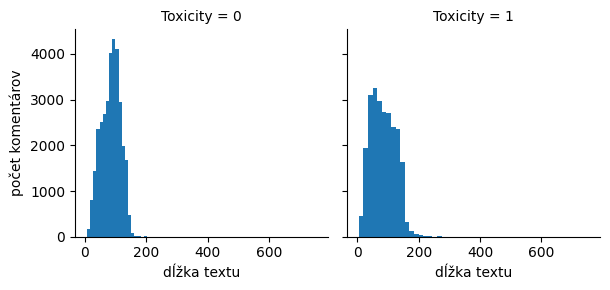

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt

# Vytvorenie FacetGrid
graph = sns.FacetGrid(data=toxic, col='Toxicity')

# Mapovanie histogramu
graph.map(plt.hist, 'dĺžka textu', bins=50)

# Nastavenie popisu osi y pre každý graf v mriežke
graph.set_ylabels('počet komentárov')

# Zobrazenie grafu
plt.show()


In [15]:
# Vypočítanie priemernej dĺžky textu pre toxické komentáre
avg_toxic_length = toxic[toxic['Toxicity'] == 1]['dĺžka textu'].mean()

# Vypočítanie priemernej dĺžky textu pre netoxické komentáre
avg_non_toxic_length = toxic[toxic['Toxicity'] == 0]['dĺžka textu'].mean()

# Porovnanie priemernej dĺžky textu pre toxické a netoxické komentáre
if avg_toxic_length > avg_non_toxic_length:
    print("Priemerná dĺžka toxických komentárov je väčšia ako priemerná dĺžka netoxických komentárov.")
elif avg_toxic_length < avg_non_toxic_length:
    print("Priemerná dĺžka toxických komentárov je menšia ako priemerná dĺžka netoxických komentárov.")
elif avg_toxic_length == avg_non_toxic_length:
  print("Priemerná dĺžka toxických komentárov sa rovná priemernej dĺžke netoxických komentárov.")
else:
    print("ERROR")


Priemerná dĺžka toxických komentárov je menšia ako priemerná dĺžka netoxických komentárov.


In [16]:
texts = toxic['tweet']
labels = toxic['Toxicity']

processed_tweets = preprocess(texts)
toxic['processed_tweets'] = processed_tweets



In [24]:
from collections import Counter

# Získanie zoznamu všetkých slov z upravených tweetov
all_words_list = [word for text in toxic['processed_tweets'] for word in text.split()]

# Spočítanie počtu výskytov každého slova
word_counts = Counter(all_words_list)

# Získanie top 10 najčastejšie sa vyskytujúcich slov
top_10_words = word_counts.most_common(10)

for word, count in top_10_words:
    print(word, "-", count)


bitch - 11553
hoe - 4370
like - 4122
love - 4020
day - 3381
get - 3046
amp - 2709
u - 2501
fuck - 2480
pussi - 2318


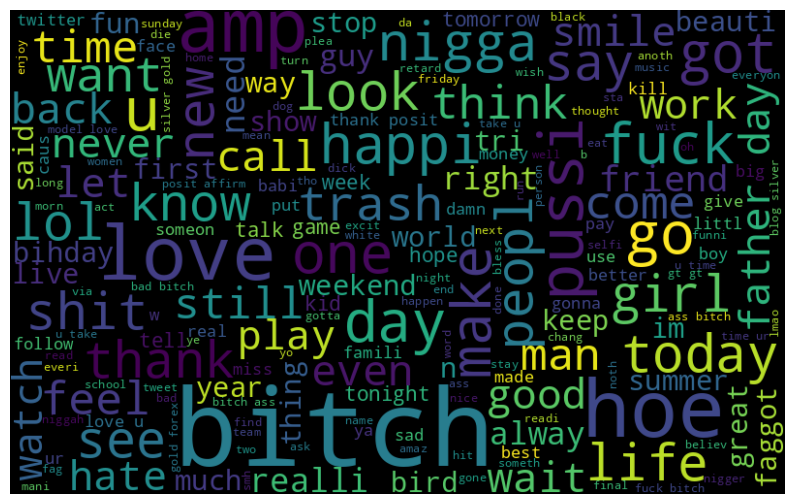

In [18]:
from wordcloud import WordCloud

# Získanie všetkých slov z upravených tweetov a spojenie do jedného reťazca
all_words = ' '.join([text for text in toxic['processed_tweets']])

# Vytvorenie wordcloudu
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# Vytvorenie obrázka wordcloudu
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()  # Zobrazenie wordcloudu


Wikipedia dataset

In [19]:
wiki = pd.read_csv('wiki.csv')
texts = wiki['comment_text']
labels = wiki['toxic']



In [20]:
wiki['dĺžka textu'] = wiki['comment_text'].apply(len)
# Vypočítanie priemernej dĺžky tweetu
average_length = wiki['dĺžka textu'].mean()

# Vytlačenie priemernej dĺžky tweetu
print("priemerna dĺžka:", average_length)


priemerna dĺžka: 394.5478


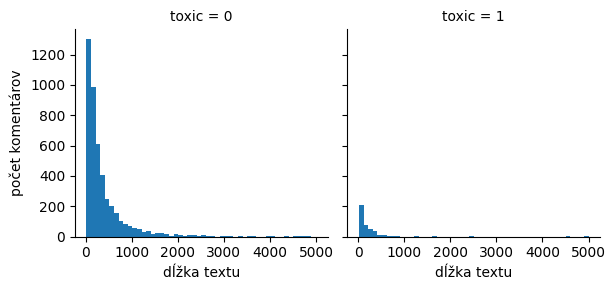

In [21]:

import seaborn as sns
import matplotlib.pyplot as plt

# Vytvorenie FacetGrid
graph = sns.FacetGrid(data=wiki, col='toxic')

# Mapovanie histogramu
graph.map(plt.hist, 'dĺžka textu', bins=50)

# Nastavenie popisu osi y pre každý graf v mriežke
graph.set_ylabels('počet komentárov')

# Zobrazenie grafu
plt.show()


In [22]:
# Vypočítanie priemernej dĺžky textu pre toxické komentáre
avg_toxic_length = wiki[wiki['toxic'] == 1]['dĺžka textu'].mean()

# Vypočítanie priemernej dĺžky textu pre netoxické komentáre
avg_non_toxic_length = wiki[wiki['toxic'] == 0]['dĺžka textu'].mean()

# Porovnanie priemernej dĺžky textu pre toxické a netoxické komentáre
if avg_toxic_length > avg_non_toxic_length:
    print("Priemerná dĺžka toxických komentárov je väčšia ako priemerná dĺžka netoxických komentárov.")
elif avg_toxic_length < avg_non_toxic_length:
    print("Priemerná dĺžka toxických komentárov je menšia ako priemerná dĺžka netoxických komentárov.")
elif avg_toxic_length == avg_non_toxic_length:
  print("Priemerná dĺžka toxických komentárov sa rovná priemernej dĺžke netoxických komentárov.")
else:
    print("ERROR")


Priemerná dĺžka toxických komentárov je menšia ako priemerná dĺžka netoxických komentárov.


In [23]:

processed_tweets = preprocess(texts)
wiki['processed_tweets'] = processed_tweets



In [25]:
from collections import Counter

# Získanie zoznamu všetkých slov
all_words_list = [word for text in wiki['processed_tweets'] for word in text.split()]

# Spočítanie počtu výskytov každého slova
word_counts = Counter(all_words_list)

# Získanie top 10 najčastejšie sa vyskytujúcich slov
top_10_words = word_counts.most_common(10)

for word, count in top_10_words:
    print(word, "-", count)


articl - 2232
page - 1874
wikipedia - 1455
edit - 1378
talk - 1322
fuck - 1198
use - 1131
pleas - 1046
ass - 990
would - 966


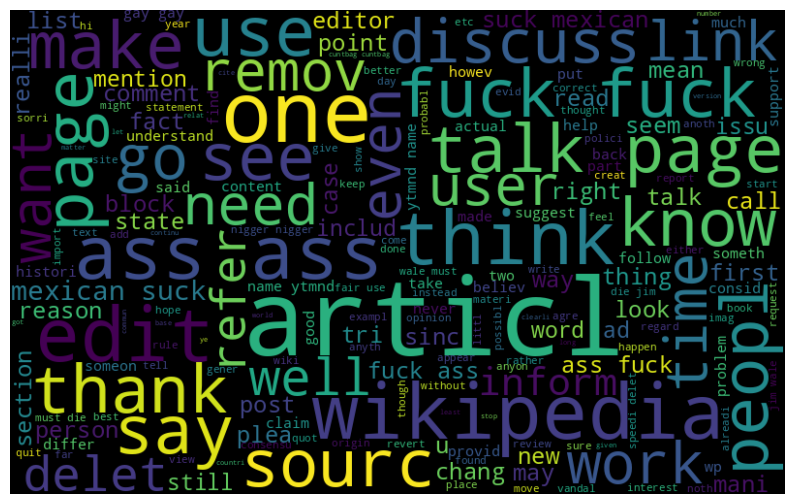

In [26]:
from wordcloud import WordCloud

# Získanie všetkých slov a spojenie do jedného reťazca
all_words = ' '.join([text for text in wiki['processed_tweets']])

# Vytvorenie wordcloudu
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# Vytvorenie obrázka wordcloudu
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()  # Zobrazenie wordcloudu
